<a href="https://colab.research.google.com/github/minghaozou/pytorch-tutorial-with-solutions/blob/main/solutions/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [41]:
# Check for GPU
!nvidia-smi

Fri Nov  7 14:46:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P0             27W /   70W |     164MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.8.0+cu126


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Add more layers/units to the model

The model may not have enough capability to learn the required patterns/representations of the data to be predictive

2. Tweak the learning rate

The model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything.

3. Use less regularization

Perhaps the model is underfitting because we are tryting to prevent overfitting too much.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [43]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [44]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [45]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [46]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(0)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image width: {img.width}")


Random Image Path: data/pizza_steak_sushi/train/sushi/2021381.jpg
Image Class: sushi
Image Height: 512
Image width: 512


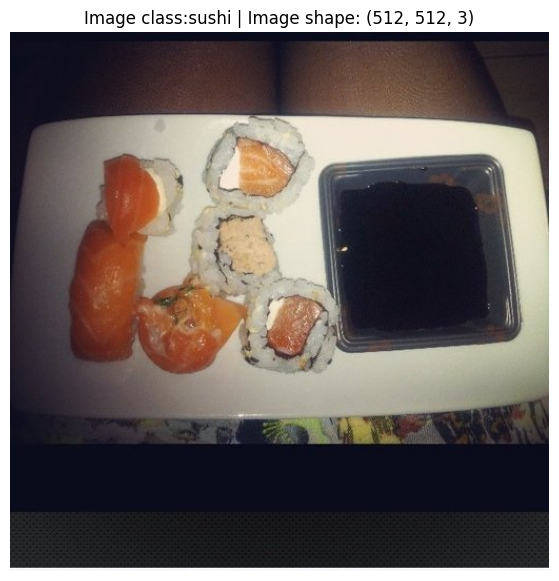

In [47]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape}")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [48]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [49]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size = (64, 64)),
    # Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

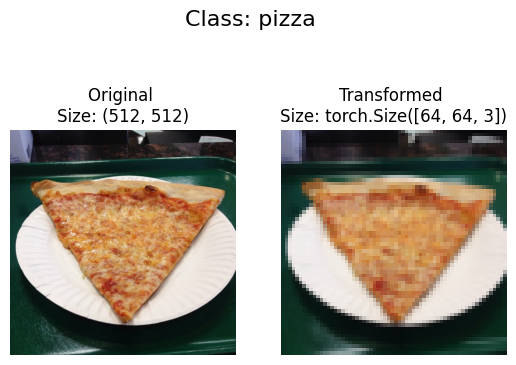

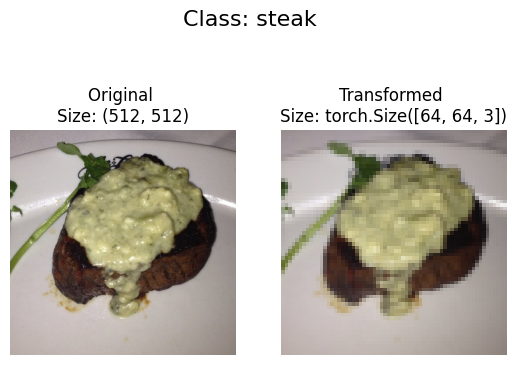

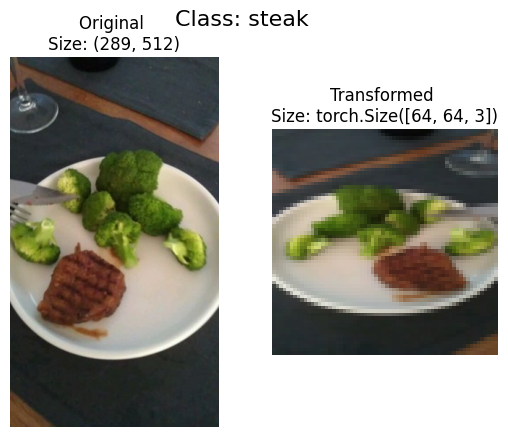

In [50]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n = 3)

### Load image data using `ImageFolder`

In [51]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform
)

print(f"Train data: \n{train_data}\nTest data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [52]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [53]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [54]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [55]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 1,
    num_workers=os.cpu_count(),
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 1,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c97f39a6f00>,
 <torch.utils.data.dataloader.DataLoader at 0x7c97f39a6ed0>)

In [56]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [57]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape= len(train_data.classes)
).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [58]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [59]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

In [60]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [61]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2800 | test_loss: 1.0960 | test_acc: 0.3733
Epoch: 2 | train_loss: 1.1010 | train_acc: 0.3244 | test_loss: 1.0996 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2978 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3333 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1004 | test_acc: 0.3333


In [62]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2800 | test_loss: 1.0959 | test_acc: 0.3467
Epoch: 2 | train_loss: 1.1026 | train_acc: 0.3467 | test_loss: 1.1080 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1014 | train_acc: 0.3200 | test_loss: 1.0993 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3156 | test_loss: 1.0996 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3111 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1006 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1019 | test_acc: 0.3333
Epoch: 12 | train_l

In [63]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2889 | test_loss: 1.0962 | test_acc: 0.3200
Epoch: 2 | train_loss: 1.1024 | train_acc: 0.3511 | test_loss: 1.1061 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1016 | train_acc: 0.3422 | test_loss: 1.0992 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3422 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3378 | test_loss: 1.1011 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0997 | train_acc: 0.3289 | test_loss: 1.1017 | test_acc: 0.3067
Epoch: 7 | train_loss: 1.0966 | train_acc: 0.3467 | test_loss: 1.1455 | test_acc: 0.2667
Epoch: 8 | train_loss: 1.1010 | train_acc: 0.3156 | test_loss: 1.1011 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0944 | train_acc: 0.3778 | test_loss: 1.1081 | test_acc: 0.4000
Epoch: 10 | train_loss: 1.1010 | train_acc: 0.3289 | test_loss: 1.0998 | test_acc: 0.3467
Epoch: 11 | train_loss: 1.0915 | train_acc: 0.3822 | test_loss: 1.0935 | test_acc: 0.3733
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [64]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0991 | train_acc: 0.3644 | test_loss: 1.0814 | test_acc: 0.3467
Epoch: 2 | train_loss: 1.0382 | train_acc: 0.4533 | test_loss: 1.0309 | test_acc: 0.4667
Epoch: 3 | train_loss: 0.9498 | train_acc: 0.5378 | test_loss: 0.9855 | test_acc: 0.5067
Epoch: 4 | train_loss: 0.9140 | train_acc: 0.6222 | test_loss: 0.9898 | test_acc: 0.5067
Epoch: 5 | train_loss: 0.8787 | train_acc: 0.6178 | test_loss: 0.9827 | test_acc: 0.4800
Epoch: 6 | train_loss: 0.8227 | train_acc: 0.6756 | test_loss: 0.9782 | test_acc: 0.4400
Epoch: 7 | train_loss: 0.8175 | train_acc: 0.6578 | test_loss: 1.0921 | test_acc: 0.5200
Epoch: 8 | train_loss: 0.7785 | train_acc: 0.6444 | test_loss: 1.0399 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.7098 | train_acc: 0.6889 | test_loss: 1.0546 | test_acc: 0.4267
Epoch: 10 | train_loss: 0.6947 | train_acc: 0.7156 | test_loss: 1.2230 | test_acc: 0.4933
Epoch: 11 | train_loss: 0.6781 | train_acc: 0.7200 | test_loss: 1.0882 | test_acc: 0.5333
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [65]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [66]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


Excellent, we now have double the training and testing images...

In [67]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [86]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  #transforms.RandomHorizontalFlip(p = 0.5),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = datasets.ImageFolder(
    root = train_data_20_percent_path,
    transform = simple_transform,
    target_transform=None
)

test_data_20_percent = datasets.ImageFolder(
    root = test_data_20_percent_path,
    transform = simple_transform
)

print(f"Train data using 20 percent data: \n{train_data_20_percent}\nTest data using 20 percent data: \n{test_data_20_percent}")

# Create dataloaders
train_dataloader_20_percent = DataLoader(
    dataset = train_data_20_percent,
    batch_size = 32,
    num_workers=os.cpu_count(),
    shuffle = True
)

test_dataloader_20_percent = DataLoader(
    dataset = test_data_20_percent,
    batch_size = 32,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader_20_percent, test_dataloader_20_percent

Train data using 20 percent data: 
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20_percent/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data using 20 percent data: 
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi_20_percent/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


(<torch.utils.data.dataloader.DataLoader at 0x7c97f3cad0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c980a8095b0>)

In [87]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3312 | test_loss: 1.1004 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0834 | train_acc: 0.3917 | test_loss: 1.0690 | test_acc: 0.4318
Epoch: 3 | train_loss: 1.0274 | train_acc: 0.4458 | test_loss: 0.9496 | test_acc: 0.5597
Epoch: 4 | train_loss: 0.9290 | train_acc: 0.5458 | test_loss: 0.9110 | test_acc: 0.6000
Epoch: 5 | train_loss: 0.8591 | train_acc: 0.6625 | test_loss: 0.9114 | test_acc: 0.5335
Epoch: 6 | train_loss: 0.8364 | train_acc: 0.6583 | test_loss: 1.0141 | test_acc: 0.4841
Epoch: 7 | train_loss: 0.8962 | train_acc: 0.5854 | test_loss: 0.8901 | test_acc: 0.5210
Epoch: 8 | train_loss: 0.7524 | train_acc: 0.6771 | test_loss: 0.9351 | test_acc: 0.5699
Epoch: 9 | train_loss: 0.7818 | train_acc: 0.6583 | test_loss: 0.9470 | test_acc: 0.5239
Epoch: 10 | train_loss: 0.8177 | train_acc: 0.6479 | test_loss: 0.9314 | test_acc: 0.5670
Epoch: 11 | train_loss: 0.7396 | train_acc: 0.6667 | test_loss: 0.8707 | test_acc: 0.6318
Epoch: 12 | train_l

Our model is still overfitting (because the train loss is far lower than the test loss), even with double the data...

It looks like we'll have to further investigate other methods of reducing overfitting to build a better model.

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [70]:
import requests

# Setup custome image path
custom_image_path = data_path / "my-sushi.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/minghaozou/pytorch-tutorial-with-solutions/raw/main/notebooks/sushi.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

In [73]:
import torchvision

# Load in custome image and convert the tensor float to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255
custom_image /= 255

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.7725, 0.7765, 0.7725,  ..., 0.0275, 0.0118, 0.0000],
         [0.7725, 0.7765, 0.7765,  ..., 0.0275, 0.0118, 0.0000],
         [0.7765, 0.7804, 0.7804,  ..., 0.0314, 0.0118, 0.0000],
         ...,
         [0.2000, 0.1373, 0.0863,  ..., 0.0039, 0.0000, 0.0000],
         [0.2118, 0.1569, 0.1059,  ..., 0.0078, 0.0000, 0.0000],
         [0.2314, 0.1843, 0.1216,  ..., 0.0039, 0.0000, 0.0039]],

        [[0.7686, 0.7725, 0.7686,  ..., 0.0000, 0.0000, 0.0000],
         [0.7686, 0.7725, 0.7725,  ..., 0.0000, 0.0000, 0.0000],
         [0.7725, 0.7765, 0.7765,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1137, 0.0588, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.1176, 0.0745, 0.0353,  ..., 0.0039, 0.0000, 0.0000],
         [0.1294, 0.0902, 0.0510,  ..., 0.0000, 0.0000, 0.0039]],

        [[0.7608, 0.7647, 0.7608,  ..., 0.0000, 0.0000, 0.0000],
         [0.7608, 0.7647, 0.7647,  ..., 0.0000, 0.0000, 0.0000],
         [0.7647, 0.7686, 0.7686,  ..

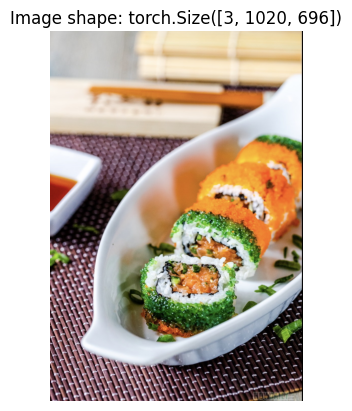

In [79]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [81]:
custome_image_transform = transforms.Compose([
  transforms.Resize((64, 64))
])

custom_image_transformed = custome_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1020, 696])
New shape: torch.Size([3, 64, 64])


In [88]:
model_4.eval()
with torch.inference_mode():
  # Add an extra dimension to image
  custome_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim = 0)

  custom_image_pred = model_4(custome_image_transformed_with_batch_size.to(device))

In [89]:
custom_image_pred

tensor([[-4.8951, -2.4359, -0.9996]], device='cuda:0')

In [90]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim = 1)
print(f"Prediction label: {custom_image_pred_label}")

custom_image_pred_class = class_names[custom_image_pred_label]
print(f"Prediction class: {custom_image_pred_class}")

Prediction probabilities: tensor([[0.0162, 0.1890, 0.7948]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')
Prediction class: sushi
